# Lab 2: Promoters, Polymerase, and Position Weight Matricies

In this lab we want to understand how the sequence of the promoter helps dictate the strength of expression and how we can use bioinformatics to identify these promoters.

**Key Concepts:**

- **Conditional gene expression:** Genes that are expressed under the same conditions often have the same regulatory sequences governing their expression. How one groups these genes can have major impacts on the regulatory seqeunces we can predict from them.

- **Consensus sequences and logos:** Biologists often represent the binding sites of regulatory proteins as "logos". These logos represent the most probable binding sequences of regulators, and often affinity of the regulator towards this "consensus" sequence dissaptes as the sequence changes.

- **Biophysical basis of promoter recognition**

- **Computer-aided promoter design:**

------------------------------------

# Import packages (Run this hidden cell)

In [ ]:
### May take a few seconds to run ### 

# Colab setup ------------------
import os, sys, subprocess
if "google.colab" in sys.modules:
    cmd = "pip install -U bokeh ipykernel holoviews bootcamp_utils logomaker"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    import bootcamp_utils.hv_defaults
else:
    print('not needed for non-colab setup')
# ------------------------------

# The Numpy package allows for better numerical computing using Python 
import numpy as np

# For this lab, we use scipy to calculate certain statistical metrics
import scipy.stats

# Pandas is a data analysis and manipulation package allowing us to do "Microsoft Excel-like" manipulations of data
import pandas as pd

# Seaborn is a data visualization package but we will use it to load in an example datasets for this exercise
import seaborn as sns

# Bokeh and holoviews are data visualization packages that we will be using to generate interactive figures
import bokeh.io
import holoviews as hv

# Logomaker allows us to create DNA logos and allows visualization of motifs
import logomaker as lm

# Further tools to make interactive plots
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image
from IPython.core.display import HTML

bokeh.io.output_notebook()
hv.extension('bokeh')
bootcamp_utils.hv_defaults.set_defaults()


##**Part 1: Putting the fun in functional genomics**

First we will download published RNAseq data that explored the transition from exponential to stationary in bioreactors. RNAseq is a powerful technique that allows researchers to "count" the abundance of mRNA transcripts in living systems. By measuring which genes are more or less abundant in different conditions we can gain insight into how organisms adapt to their environment. We will cover RNAseq in more depth later in the course.

#**Lab Background**

In this lab we will explore the concepts of conditional gene expression and the "consensus" promoter sequence through the lens of the model bacterium *Escherichia coli*. Though we will provide a great deal of biological detail on the behavior and physiology of the bacteria, this is not a microbiology course. The detail is presented here to encourage you to think about key concepts of this lab as if you were conducting independent research. 

When growing in rich media *E. coli* can replicate itself every 20 minutes. This rapid growth is often called logarithmic or exponential growth (Figure 1). This exponential growth continues unabated until one or more key resources become limiting to cells at which point cell division halts and the population enters stationary phase (Figure 1). As the bacteria enter stationary phase, they undergo a massive reallocation of their cellular resources to optimize their physiology for survival instead of rapid growth which is called the stringent response.

![here](https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/growth_curve.png)

**Figure 1:** *In standard laboratory conditions bacteria will grow in four distinct phases: Lag Phase, Exponential Phase, Stationary Phase, and Death Phase. During lag phase the bacteria that have encountered a new environment must reallocate their physiology so that they rapidly grow. During exponential phase the cells are optimized for rapid cell division and undergo logarithmic proliferation. As environmental resources run out the cells enter stationary phase, where cell division halts and the bacteria once again reallocate their physiology to optimize for survival. If the bacteria remain stationary phase long enough without additional resources they will begin to lose viability as their cellular integrity deteriorates and they enter death phase.*



A hallmark of the stringent response is the downregulation of RNAs and proteins that are required at high levels for super fast growth. These factors (such as ribosome components like 16S rRNA, elongation factors like EF-Tu, and RNA processing factors like tmRNA and RNase P) are expressed from very *strong* promoters during exponential phase recognized by the housekeeping RNA polymerase (RNAP) sigma factor 70 (σ70). These strong promoters are able to efficiently recruit RNAP and initiate transcription under fast growing conditions, but their transcriptional output is heavily *downregulated* in stationary phase. This downregulation occurs because the cell produces chemical signals and proteins that work together to decrease the affinity of RNA polymerase to these promoters (Figure 2). By decreasing the affinity for RNAP towards these normally very strong σ70 promoters the cell is able to rapidly conserve resources by limiting translation and allowing for the expression of other genes that will allow it to survive in a more austere environment.

<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/stringent_response.png" height=750>

**Figure 2:** *E. coli perceives starvation through uncharged tRNAs entering into the ribosome. This activates the synthesis of the small molecule "alarmone" ppGpp. At high concentrations ppGpp will interact with other proteins in the cell to help repress sig70 promoters that express housekeeping genes that are required at high levels for fast growth. Figure adapted from Vinogradova et al. 2020, (https://doi.org/10.1371/journal.pbio.3000593).* 

Below we will look at real life RNAseq data to identify genes that are strongly downregulated during the transition to stationary phase. Once we have identified those genes, we will use bioinformatics to isolate key sequence elements in the upstream regions of these genes that confer strong expression during exponential growth. After identifying which sequences confer strong expression strengths during exponential phase, we will explore the biophysical basis of this strength by examining protein crystal structures of DNA interacting with RNA-polymerase. Finally we will use predictive software the understand how changing specific sequence elements in the promoters can result in changes in promoter strengths.



In [ ]:
#parse in RNAseq data and gene metadata 
df = pd.read_excel('https://github.com/shih-lab/BIS198/blob/main/datasets/ecolirnaseq.xlsx?raw=true',sheet_name='counts')
df = df[["ID", "SynH_Exp_BXHU", "SynH_Stat1_CUOC"]]
df_genes = pd.read_excel('https://github.com/shih-lab/BIS198/blob/main/datasets/ecolirnaseq.xlsx?raw=true',sheet_name='genes')
df_rna = pd.merge(df_genes[['Gene Name', 'ID','Product']],df,on='ID')

#add one to all RNAseq counts because we don't like dividing by 0
df_rna['SynH_Exp_BXHU']=df_rna['SynH_Exp_BXHU']+1
df_rna['SynH_Stat1_CUOC']=df_rna['SynH_Stat1_CUOC'] +1

#calculate the log2-fold change of genes in stationary phase compared to exponential phase
df_rna['ratio'] = df_rna['SynH_Stat1_CUOC']/df_rna['SynH_Exp_BXHU']
df_rna['log2change'] = np.log2(df_rna['ratio'])

#calculate the count changes in genes in stationary phase compared to exponential phase
df_rna['counts_change'] = df_rna['SynH_Stat1_CUOC'] - df_rna['SynH_Exp_BXHU']

In [ ]:
#visualize a small segment of the dataframe
df_rna.iloc[1000:1005]

,Gene Name,ID,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,ratio,log2change,counts_change
1000,rhsA,b3593,rhs element protein RhsA,366,10019,27.374317,4.774751,9653
1001,yibF,b3592,glutathione transferase-like protein YibF,208,1199,5.764423,2.527176,991
1002,selA,b3591,selenocysteine synthase,1966,3509,1.784842,0.835797,1543
1003,selB,b3590,selenocysteyl-tRNA-specific translation elonga...,3610,4915,1.361496,0.445193,1305
1004,yiaY,b3589,L-threonine dehydrogenase,28,1916,68.428571,6.096527,1888


We have now parsed in the RNAseq count data and merged it with metadata that gives us some information about each genes function.

-----------------------------------------------

**Gene Name**: The common name given to genes by researchers over the last 75 years as the function of genes were learned.

**ID**: A unique identifier for each gene in *E. coli* that is more systematic and "machine readable".

**Product**: The known or predicted function of a gene. Genes with unknown functions are often annotated as "hypothetical proteins".

**SynH_Exp_BXHU**: RNA counts under exponential conditions.

**SynH_Stat1_CUOC**: RNA counts under stationary conditions.

**ratio**: For each gene, this metric represents the counts from stationary phase divided by the counts from exponential phase.

**log2change**: This is the log2 transformed ratio. Researchers commonly present changes in expression as log2 transformed data.

**counts_change**: This is the total number of counts from stationary phase minus the total number of counts from exponential phase.

----------------------------------------

**Question 1:** What does the log2change column tell us about a gene in this experiment? What has happened to a genes expression in this experiment if the number is negative? If it is positive?

**Question 2:** Why might it be informative to look at not only the log2change but also the absolute change in counts between conditions?

-----------------------------------------------------------------
So let's plot this data and see if we can observe any trends.

<Figure size 720x720 with 0 Axes>

Text(0.5, 0, 'log2 counts Exponential')

Text(0, 0.5, 'log2 counts Stationary')

(-0.5, 20.0)

(-0.5, 20.0)

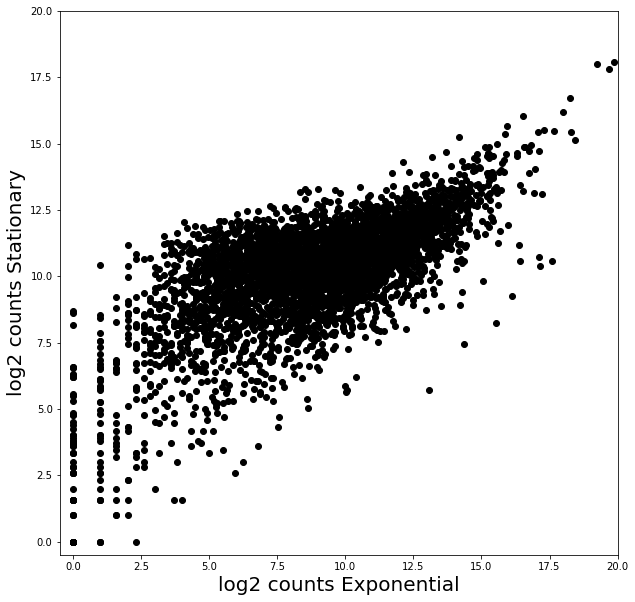

In [ ]:
#scatter plot of the counts of the two growth conditions
plt.figure(figsize=(10,10))
plt.scatter(df_rna['SynH_Exp_BXHU'].apply(lambda x: np.log2(x)),
            df_rna['SynH_Stat1_CUOC'].apply(lambda x: np.log2(x)),color='black')

plt.xlabel('log2 counts Exponential',size=20)
plt.ylabel('log2 counts Stationary',size=20)
plt.xlim(-0.5,20)
plt.ylim(-0.5,20)

We have now plotted the two RNAseq datasets against one another on a single scatterplot, where the axes express log2 transformed counts.

**Question 3:** What does each datapoint represent?

**Question 4:** Where on this plot do we see changes that show genes that are most highly expressed in exponential phase, but not in stationary phase? What about genes that are highly expressed in exponential phase, but not as highly expressed in stationary phase?

------------------------------------------



The plot above however doesn't tell us much about the biological function of those genes that are differentially expressed in these two conditions. By simply sorting the dataframe by log2change or counts_change we can inspect the function of these genes.

By sorting the dataframe by the largest positive log2change we can identify which genes are most relatively upregulated during the exponential to stationary transition.

In [ ]:
df_rna[['Gene Name','Product','SynH_Exp_BXHU','SynH_Stat1_CUOC',
       'log2change','counts_change']].sort_values(by='log2change',ascending=False).head(10)

,Gene Name,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,log2change,counts_change
543,phnH,carbon-phosphorus lyase core complex subunit PhnH,2,1362,9.411511,1360
544,phnI,carbon-phosphorus lyase core complex subunit PhnI,4,2328,9.184875,2324
2058,eutN,putative ethanolamine catabolic microcompartme...,1,410,8.679480,409
3762,ybeT,Sel1 repeat-containing protein YbeT,1,392,8.614710,391
1015,yiaN,"2,3-diketo-L-gulonate:Na<sup>+</sup> symporter...",5,1823,8.510171,1818
3133,ycjU,&beta;-phosphoglucomutase,4,1343,8.391244,1339
539,phnC,phosphonate/phosphate ABC transporter ATP bind...,5,1596,8.318317,1591
540,phnD,phosphonate/phosphate ABC transporter periplas...,10,2957,8.207990,2947
73,ytcA,putative lipoprotein YtcA,1,290,8.179909,289
2888,insD7,Qin prophage; putative transposase,6,1627,8.083036,1621


Among the most relatively upregulated genes we see that phnH, phnI, phnC, phnD are all highly upregulated (~500x greater expression during stationary phase). These genes are all involved in phosphate scavenging and transport.

**Question 5:** In this experiment what was most likely a limiting nutrient as the cells entered stationary phase? Based on the expression of the phn genes during exponential phase can we infer anything about the initial concentration of phosphate available to the cultures?

-------------------------------------------------------------------

When we sort the data frame by greatest absolute positive difference in counts (counts_change), we see that different genes are at the top of the list.

In [ ]:
df_rna[['Gene Name','Product','SynH_Exp_BXHU','SynH_Stat1_CUOC',
       'log2change','counts_change']].sort_values(by='counts_change',ascending=False).head(10)

,Gene Name,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,log2change,counts_change
4369,thrA,fused aspartate kinase/homoserine dehydrogenase 1,18297,38832,1.085639,20535
4264,aceE,pyruvate dehydrogenase E1 component,4427,20500,2.211223,16073
2100,cysK,cysteine synthase A,9227,22902,1.311540,13675
1028,xylA,xylose isomerase,13390,26193,0.968025,12803
4263,aceF,AceF-dihydrolipoate // AceF-S-acetyldihydrolip...,3333,15117,2.181279,11784
180,ydbA,"putative outer membrane protein, N-terminal fr...",5237,15549,1.570009,10312
3420,putA,fused DNA-binding transcriptional repressor / ...,510,10181,4.319238,9671
1000,rhsA,rhs element protein RhsA,366,10019,4.774751,9653
3721,rhsC,rhs element protein RhsC,1471,10618,2.851643,9147
3903,rhsD,protein RhsD,795,9827,3.627724,9032


Amongst the top most upregulated genes by absolute counts for thrA (a gene required for the synthesis of the amino acid threonine), and cysK (a gene required for the synthesis of the amino acid cysteine).

**Question 6:** What does the observed upregulation of these genes imply about the internal pools of threonine and cysteine during stationary phase? Why do you think that though these genes are amongst the most absolutely upregulated genes when measured by counts, that neither of these genes show a particularly large log2change (<2)?

------------
We have already looked at what is most upregulated during the exponential--> stationary phase transition.  Now let's look at what is downregulated during this transition.

In [ ]:
df_rna[['Gene Name','Product','SynH_Exp_BXHU','SynH_Stat1_CUOC',
       'log2change']].sort_values(by='log2change',ascending=True).head(10)

,Gene Name,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,log2change
1080,gadE,DNA-binding transcriptional activator GadE,8655,52,-7.378878
1082,hdeA,periplasmic acid stress chaperone HdeA,47430,300,-7.304694
2970,gadB,glutamate decarboxylase B,196014,1537,-6.994696
1083,hdeB,periplasmic acid stress chaperone HdeB,21226,176,-6.914113
408,pyrI,"aspartate carbamoyltransferase, PyrI subunit",71072,608,-6.869066
2971,gadC,L-glutamate:4-aminobutyrate antiporter,146286,1329,-6.782307
407,pyrB,aspartate carbamoyltransferase catalytic subunit,140918,1708,-6.366404
2670,dmlA,D-malate/3-isopropylmalate dehydrogenase (deca...,87244,1543,-5.821246
1086,slp,starvation lipoprotein,18758,480,-5.288328
409,ridA,"enamine/imine deaminase, redox-regulated chape...",34381,897,-5.260360


[link text](https://)You'll notice that some of the most downregulated genes (gadE, gadB, gadC, and hbeB) are all involved in acid stress. This is likely due to the fact that when growing at its fastest *E. coli* grows via fermentation, resulting in the production of many acidic byproducts such as acetate. Thus fast growing cells must contend with this acidic stress.

--------------

Now lets explore the genes that are most  downregulated when measured by change in counts during the transition to stationary phase.

In [ ]:
df_rna[['Gene Name','Product','SynH_Exp_BXHU','SynH_Stat1_CUOC',
       'log2change','counts_change']].sort_values(by='counts_change',ascending=True).head(20)

,Gene Name,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,log2change,counts_change
1446,rnpB,RNase P catalytic RNA component,949408,275071,-1.787224,-674337
1900,ssrA,tmRNA,836700,230403,-1.860551,-606297
261,csrB,small regulatory RNA CsrB,623178,260368,-1.259092,-362810
2287,ompC,outer membrane porin C,353442,36375,-3.280454,-317067
2691,gapA,glyceraldehyde-3-phosphate dehydrogenase A,318154,45160,-2.816608,-272994
3209,adhE,fused acetaldehyde-CoA dehydrogenase and iron-...,309420,108494,-1.511951,-200926
2970,gadB,glutamate decarboxylase B,196014,1537,-6.994696,-194477
1244,fusA,elongation factor G,259693,76012,-1.772508,-183681
3475,ompA,outer membrane protein A,206754,45709,-2.177365,-161045
2971,gadC,L-glutamate:4-aminobutyrate antiporter,146286,1329,-6.782307,-144957


When we look at the genes that have the greatest absolute decreases in gene counts we find that many of them are  involved with the central dogma:

**rpnB** - processes tRNA which are required for translation

**ssrA** - fixes stalled ribosomes which occurs often in fast growing cells and is lethal if not resolved

**tufB, tufA, fusA, rpsA** - ribosomal proteins that are critical to either ribosome formation or translation

**rpoC** - The major structural subunit of RNA polymerase

As we mentioned in the introduction the downregulation of these genes reflect the cells survival strategy to stop optimizing for growth to transition to a more sparse environment.

**Question 7:** Based on what we have observed amongst the genes that are up and downregulated in these conditions do you notice any trends for the types of genes that are highly differentially regulated during the transition to stationary phase when we sort by log2change but do not necessarily have large absolute changes? Conversely what kind of genes tended to show large absolute changes in gene counts, but did not necessarily have dramatic log2changes?

----------------


Now that we have learned a little about the biological function of the genes that are more or less expressed in either condition, lets explore the data in a more systematic fashion.



## **Detecting upregulated and downregulated genes**

Below, we will render a visulization of the RNA counts at Stationary vs Exponential Growth phase.  The slider will apply a threshold $n$ where a gene is considered up or down regulated if they are $2^n$-fold more or less expressed in one growth phase versus the other.  

Equivalently if:
$$\left|log2\left(\frac{\textrm{Counts}_{stationary}}{\textrm{Counts}_{exponential}}\right)\right| > n$$
then the gene is considered up or down regulated depending on the sign of the log ratio.

In [ ]:
log_slide = pd.read_csv("https://raw.githubusercontent.com/shih-lab/BIS198/main/datasets/log2_slider.csv")
hv.extension('bokeh')
hv.output(widget_location='bottom')

my_count = hv.Bars(
    data=log_slide,
    kdims=['Threshold of 2^n where n is', 'binned']
).aggregate(
    function=len
).groupby(
    "Threshold of 2^n where n is"
).opts(
    xlabel="",
    ylabel="Counts",
    width=300,
    height=300
)

my_fig = hv.Points(
    data=log_slide,
    kdims=['SynH_Exp_BXHU', 'SynH_Stat1_CUOC'],
    vdims=['binned', 'Threshold of 2^n where n is', "Gene Name", "log2change"]
).groupby(
    ['Threshold of 2^n where n is', 'binned']
).opts(
    tools=['hover'],
    logx=True,
    logy=True,
    alpha=0.3,
    xlabel="Exponential Growth Gene Counts",
    ylabel="Stationary Growth Gene Counts"
).overlay(
    ['binned']
)
my_fig.get_dimension('binned').label='Stationary vs Exponential'
my_count.opts(title="# of Genes") + my_fig.opts(width=700, height=500, title="RNA Counts")

**Question 8:** Why would a researcher be interested in examining genes that are up or downregulated at different thresholds?

**Question 9:** As the arbitrary threshold n is changed what trends do you notice in terms of the number of genes that we consider differently expressed? 

**Question 10:** As we transition to stationary phase do we tend to see more genes up or downregulated when we measure the difference by log2change at higher thresholds? Why might this be?

-----------------

Next, we will apply a threshold $n$ where a gene is considered up or down regulated if they have $n$ more or less counts in one growth phase versus the other.

In this case if:
$$\left|\textrm{Counts}_{stationary} - \textrm{Counts}_{exponential}\right| > n$$
then the gene is considered up or down regulated depending on the sign of the difference in counts.

In [ ]:
count_slide = pd.read_csv("https://raw.githubusercontent.com/shih-lab/BIS198/main/datasets/count_slider.csv")
hv.extension('bokeh')
hv.output(widget_location='bottom')

my_count = hv.Bars(
    data=count_slide,
    kdims=['Threshold where |count difference| is', 'binned']
).aggregate(
    function=len
).groupby(
    "Threshold where |count difference| is"
).opts(
    xlabel="",
    ylabel="Counts",
    width=300,
    height=300
)
my_fig = hv.Points(
    data=count_slide,
    kdims=['SynH_Exp_BXHU', 'SynH_Stat1_CUOC'],
    vdims=['binned', 'Threshold where |count difference| is', "Gene Name", "log2change"]
).groupby(
    ['Threshold where |count difference| is', 'binned']
).opts(
    tools=['hover'],
    logx=True,
    logy=True,
    alpha=0.3,
    xlabel="Exponential Growth Gene Counts",
    ylabel="Stationary Growth Gene Counts"
).overlay(
    ['binned']
)
my_fig.get_dimension('binned').label='Stationary vs Exponential'
my_count.opts(title="# of Genes") + my_fig.opts(width=700, height=500, title="RNA Counts")

**Question 11:** As we transition to stationary phase do we tend to see more genes up or downregulated when we measure the difference by counts_change at higher thresholds? Why might this be?

**Question 12:** Depending on how we define our cutoffs (by measuring counts vs. log2change) what biases may we introduce into our analysis? Specifically, what types of genes may appear based on one set of thresholds or criteria, but not another?

-------------------

## **Part 2: Getting Motifs from Expression Data**

Transition. Why did we bother doing conditional gene expression. What is a consensus sequence.

**Let's further analyze the genes which are downregulated in stationary growth**

We can use the `log2change` column of our dataframe `df_rna` to select for genes that were downregulated in stationary phase.


$$\frac{\textrm{counts}_{stat}\textrm{ for gene X}}{\textrm{counts}_{exp}\textrm{ for gene X}} = 2^n$$
Then
$$\log_2\left(\frac{\textrm{counts}_{stat}\textrm{ for gene X}}{\textrm{counts}_{exp}\textrm{ for gene X}}\right) = n$$

For downregulated genes in stationary phase, $n$ is negative and depending on our thresholding, these genes are expressed $2^n$-fold less in stationary growth when compared to exponential growth

In [ ]:
#We can create a boolean query of the log2change column to find all genes which have a value of -5
df_rna.log2change < -5

0       False
1       False
2       False
3       False
4       False
        ...  
4366    False
4367    False
4368    False
4369    False
4370    False
Name: log2change, Length: 4371, dtype: bool

In [ ]:
# We can then apply this boolean dataframe to the rna-seq dataframe to get the list of genes which have a log2 fold change of -5 or smaller
df_rna[df_rna.log2change < -5]

,Gene Name,ID,Product,SynH_Exp_BXHU,SynH_Stat1_CUOC,ratio,log2change,counts_change
407,pyrB,b4245,aspartate carbamoyltransferase catalytic subunit,140918,1708,0.012121,-6.366404,-139210
408,pyrI,b4244,"aspartate carbamoyltransferase, PyrI subunit",71072,608,0.008555,-6.869066,-70464
409,ridA,b4243,"enamine/imine deaminase, redox-regulated chape...",34381,897,0.026090,-5.260360,-33484
1075,gadA,b3517,glutamate decarboxylase A,84374,2314,0.027426,-5.188338,-82060
1080,gadE,b3512,DNA-binding transcriptional activator GadE,8655,52,0.006008,-7.378878,-8603
1082,hdeA,b3510,periplasmic acid stress chaperone HdeA,47430,300,0.006325,-7.304694,-47130
1083,hdeB,b3509,periplasmic acid stress chaperone HdeB,21226,176,0.008292,-6.914113,-21050
1086,slp,b3506,starvation lipoprotein,18758,480,0.025589,-5.288328,-18278
2670,dmlA,b1800,D-malate/3-isopropylmalate dehydrogenase (deca...,87244,1543,0.017686,-5.821246,-85701
2970,gadB,b1493,glutamate decarboxylase B,196014,1537,0.007841,-6.994696,-194477


We pull out the 11 genes which correspond to the 11 blue dots in the log-threshold slider figure above.

**Question 13:** How much more or less are these 11 genes expressed in stationary phase versus exponential phase?


-----------
Focusing on the 11 downregulated genes in stationary phase, we can try to see if we can extract any additional information at the DNA-sequence level.  We know that these genes all have a corresponding promoter sequence which acts to regulate the gene expression.  We will explore how we can find patterns in these promoter sequences.

In [ ]:
# Lets make a list of the names of some downregulated genes in stationary phase
my_eleven_genes = df_rna[df_rna.log2change < -5]["Gene Name"].to_list()
my_eleven_genes

['pyrB',
 'pyrI',
 'ridA',
 'gadA',
 'gadE',
 'hdeA',
 'hdeB',
 'slp',
 'dmlA',
 'gadB',
 'gadC']

In [ ]:
# import promoter database into dataframe
promoters = pd.read_csv("https://raw.githubusercontent.com/shih-lab/BIS198/main/datasets/ecocyc_promoter_sequences.csv")

# Make some functions to lookup promoter sequences and generate logos
def promoter_lookup(gene_list, df_prom):
    seq_list = []
    prom_list =[]
    for gene in gene_list:
        seq_list = np.append(seq_list, df_prom.query('@gene in downstream_genes')[["upper_seq"]].dropna().values)
        seq_list = np.append(seq_list, df_prom[df_prom.promoter.str.contains(gene)].upper_seq.values)
    return np.unique(seq_list)

def generate_logo(seq_list):
    counts_mat = lm.alignment_to_matrix(seq_list)
    info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')
    graph = lm.Logo(info_mat)
    graph.ax.set_xticks(range(0,len(info_mat),5))
    graph.ax.set_xticklabels('%+d'%x for x in range(-60,25,5))
    return graph

We can try to map these genes to their promoter sequence by querying a database which contains all *E.coli* promoter sequences for all genes. In general bacterial promoters tend to occur ~50-200 base pairs upstream of a gene's start codon.


<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/consensus_illustration.png" height=250>


**Figure 3:** Make it clear to kids what is important in the figure

We have made a `promoter_lookup()` function which does just that.  For the 11 genes, the `promoter_lookup()` function found 13 promoter sequences.
This is because there are 3 putative promoter sequences for gadC instead of 1 which leads to 13 sequences instead of 11 for the whole list.
We will ignore this for this lab but this does mean that gadC promoters are slightly overrepresented for the following exercises.

In [ ]:
# Outputs an array of promoter sequences from -60 to +25 for each gene relative to the transcriptional start site
seq_list = promoter_lookup(my_eleven_genes, promoters)
seq_list

array(['AATGTGGTGCTGGCCAATTAATTGCGGTTGGTAATAAAAGTCTGGCTCCCTATAATGAGCCAGACTTTTTACCGCTGTAATAAAG',
       'ATATTGAACAACGATTCGGACAAGGATGTAAATAATGAAAAGGATGACATATTCGAAACGATAACGGCTAAGGAGCAAGTTATGA',
       'CCAATTGCCAGCTTAAGTCGAAACAAGGAGACTCGATATTTAAATCGGATTACATTTTAACTTTAGTAATATTCTTCAGAGATCA',
       'TAACGGTAACGGTGTCCCGAAACGAACCCGTTTCGGGACAATTTCCAAAGTCTGTTCACTGGCATTAGCAACGGAAAATATTGTT',
       'TAACGTTTAACGGTAACGGTGTCCCGAAACGAACCCGTTTCGGGACAATTTCCAAAGTCTGTTCACTGGCATTAGCAACGGAAAA',
       'TATCAGGCATATCACCTCAGAATCAGATGAAAACTATAAAGAAATATCTATTATGGTTTTAATATTTGTTGATAAGGATAGTAAC',
       'TATTTAAACACGAGTCCTTTGCACTTGCTTACTTTATCGATAAATCCTACTTTTTTAATGCGATCCAATCATTTTAAGGAGTTTA',
       'TATTTAAATTAAGCCTGTAATGCCTTGCTTCCATTGCGGATAAATCCTACTTTTTTATTGCCTTCAAATAAATTTAAGGAGTTCG',
       'TCTGATTTTGATATTTTCCATCAACATGACATATACAGAAAACCAGGTTATAACCTCAGTGTCGAAATTGATTCGTGACGGCTCT',
       'TCTGTTCACTGGCATTAGCAACGGAAAATATTGTTCTGAATACGCTTCAGAACAAAACAGGTGCGGTTCCGACAGGAATACCGTT',
       'TGTAACAACACCACGTTTAGCGTTTGCTCCAG

In order to visualize patterns in the DNA-sequences of the genes we enriched, we will be using the python package [`logomaker`](https://github.com/jbkinney/logomaker) by Ammar Tareen and Justin B. Kinney.  We will generate various logos and tie them back to biological consequences.

To start we will generate a counts matrix of the 13 DNA-sequences we just pulled out of the `df_rna` which are downregulated in stationary phase.

,A,C,G,T
pos,,,,
0,2.0,1.0,0.0,10.0
1,6.0,3.0,1.0,3.0
2,6.0,0.0,0.0,7.0
3,2.0,3.0,5.0,3.0
4,3.0,1.0,3.0,6.0


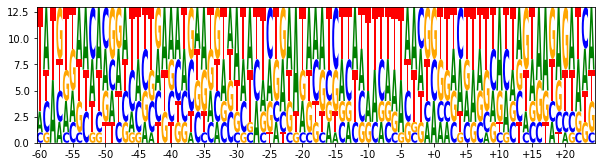

In [ ]:
counts_mat = lm.alignment_to_matrix(seq_list)
counts_mat.head(5)

graph = lm.Logo(counts_mat)
_ = graph.ax.set_xticks(range(0,len(counts_mat),5))
_ = graph.ax.set_xticklabels('%+d'%x for x in range(-60,25,5))

Counts logos are assigned character heights corresponding to these $n_{ic}$ values. Where $i$ corresponds to position and $c$ to nucleotide. The y axis of such logos extends from 0 to
$N$, where $N$ is the number of sequences in the alignment.

**Question 14:** 
How many promoters contribute to this count logo?

What is $n$ at $i = 3$ and $c = G$ in the count matrix above? 

What is $n$ at $i = 2$ and $c = G$ in the count matrix above?

,A,C,G,T
pos,,,,
0,0.153846,0.076923,0.000000,0.769231
1,0.461538,0.230769,0.076923,0.230769
2,0.461538,0.000000,0.000000,0.538462
3,0.153846,0.230769,0.384615,0.230769
4,0.230769,0.076923,0.230769,0.461538


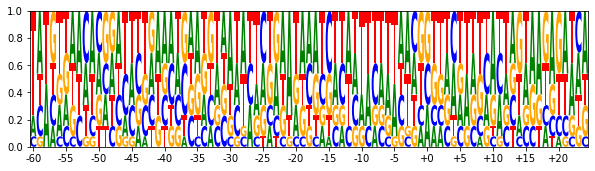

In [ ]:
prob_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='probability', pseudocount=0)
prob_mat.head(5)

graph = lm.Logo(prob_mat)
_ = graph.ax.set_xticks(range(0,len(prob_mat),5))
_ = graph.ax.set_xticklabels('%+d'%x for x in range(-60,25,5))

The probability matrix has entries $p_{ic}$ for the probability of a nucleotide $c$ at position $i$

Looking at a singular case, the probability of $T$ appearing at position $0$ is $$\frac{\textrm{frequency of T}}{\textrm{number of total sequences}} = \frac{10}{13} \approx 0.77$$

**Question 15:** What is the probability of $T$ at position two? 

How many promoters have $T$ at position two?

**Question 16:** If 100 more promoters are added to this dataset, none of which have a $T$ at position 2, what would the new probabilty for $T$ be at position 2?

---------

Information logos are great for extracting sequence motifs from the promter sequences.  First we generate an information matrix.

The entries $I_{ic}$ in the corresponding information matrices
are given by

$I_{ic} = p_{ic} I_i,~~~I_i = \sum_c p_{ic} \log_2 \frac{p_{ic}}{b_{ic}}$

where $p_{ic}$ are the probabilities of nucleotide $c$ in position $i$

The position-dependent (but not character dependent) quantity $I_i$ is called the "information content"
of site $i$. 

$b_{ic}$ is the background probability of the nucleotide $c$ at position i and in our case is always $\frac{1}{4}$ or $0.25$. Because *E. coli* has a genome GC-content of $50.8\%$, we do not need to adjust the background probability.  However for some theromophilic microbes, GC content can be upwards of $70\%$

These information values $I_{ic}$  are nonnegative and are said to be in units of
'bits' due to the use of $\log_2$.  Another caveat of using $\log$ is that we must add a "pseudocount" to all values in the count matrix or else we would be evalulating $\log_2(0)$ which is $-\infty$.  

In other words, for the count matrix above, which has no $G$s at position zero, we would add one pseudocount to that value as well as all other values in the matrix and thus the count matrix row would transform from $[2 ,1 ,0 ,10]$ to $[3,2,1,11]$ before we convert the count matrix into an information matrix.

,A,C,G,T
pos,,,,
0,0.096766,0.064510,0.032255,0.354808
1,0.052430,0.029960,0.014980,0.029960
2,0.197759,0.028251,0.028251,0.226010
3,0.008074,0.010765,0.016148,0.010765
4,0.029960,0.014980,0.029960,0.052430


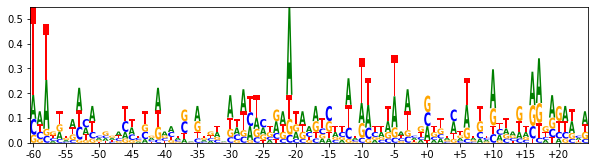

In [ ]:
info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information', pseudocount=1)
info_mat.head(5)

graph = lm.Logo(info_mat)
_ = graph.ax.set_xticks(range(0,len(info_mat),5))
_ = graph.ax.set_xticklabels('%+d'%x for x in range(-60,25,5))

**Question 17:** What is the information content for $T$ in position 0 vs 1?  Using the count matrix and the probability matrix above, why are the information values at positions 0 and 1 so different? (Hint: It may be easier to answer this question after running the next cell)


------

Now let's look at what happens if we generate logos from sequences as we change the fold-change threshold

In [ ]:
# Here we can apply the same boolean dataframes for different log fold-change thresholds
Down_5 = df_rna[df_rna.log2change < -5]
Down_4 = df_rna[df_rna.log2change < -4]
Down_3 = df_rna[df_rna.log2change < -3]
Down_2 = df_rna[df_rna.log2change < -2]
Down_1 = df_rna[df_rna.log2change < -1]

# Be patient, this cell takes a moment to load as well as reload graphs when you change options using the dropdown menu
seq_list0 = promoter_lookup(Down_5["Gene Name"].to_list(), promoters)
seq_list1 = promoter_lookup(Down_4["Gene Name"].to_list(), promoters)
seq_list2 = promoter_lookup(Down_3["Gene Name"].to_list(), promoters)
seq_list3 = promoter_lookup(Down_2["Gene Name"].to_list(), promoters)
seq_list4 = promoter_lookup(Down_1["Gene Name"].to_list(), promoters)

d_seq_lists = {"2^5":seq_list0,
 "2^4":seq_list1,
 "2^3":seq_list2,
 "2^2":seq_list3,
 "2^1":seq_list4
}

def f(threshold):
    seq_list = d_seq_lists[threshold]
    counts_mat = lm.alignment_to_matrix(seq_list)
    info_mat = lm.transform_matrix(counts_mat, from_type='counts', to_type='information')
    graph = lm.Logo(info_mat)
    graph.ax.set_xticks(range(0,len(info_mat),5))
    graph.ax.set_xticklabels('%+d'%x for x in range(-60,25,5))
    print("Information logo generated using","\033[1m", len(seq_list),"\033[0m", "sequences from genes downregulated in stationary phase by", "\033[1m",threshold,"\033[0m" + "-fold")

_ = interact(f, threshold=["2^5","2^4", "2^3", "2^2", "2^1"])

interactive(children=(Dropdown(description='threshold', options=('2^5', '2^4', '2^3', '2^2', '2^1'), value='2^…

**Question 18:** As we lower the threshold, and increase the number of sequences in the information logo, do most of the positions increase or decrease in information content? Why is this?

**Question 19:** If we could generate DNA where the base choice is completely random, what would the information logo calculated from all those sequences look like?

**Question 20:** Change threshold to $2^2$ which shows the information logo for 276 of the most downregulated promoters in stationary phase. Based on the resulting logo and Fig 3, which elements of the *E. coli* sig70 promoter can be identified in the logo?

##**Part 3: Why do these motifs matter?**

The sequence motifs that we generated from our bioinformatic analysis appeared for a reason. They have evolved to interact with specific domains of bacterial RNA polymerase. As mentioned in lecture, bacterial RNA polymerase recognizes and "melts" promoters via the sigma subunit. The housekeeping sigma factor sig70, responsible for the expression of the majority of genes in *E. coli*, has multiple domains within each responsible for different tasks during transcription initiation (Figure 4A).

<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/sig702_sig704_interaction.png" height=750>

**Figure 4:**




Two of the most important of these domains are sig2, which recognizes the -10 element, and sig4, which recognizes the -35 element. Both domains form "helix-turn-helix" motifs that are able to fit into the major groove of the promoter DNA and interact with specific nucleotides (Figure 4B).

**Question 21:** Looking at the logo you generated in Question 20, which element of the bacterial promoter is more important for gene expression: the -35 element or the -10 element? *Based on the logo* how did you come to this conclusion? *Biologically*, why might this element be more important?

**Question 22:** Based on Figure 4B what would happen to the function of the promoter if we were to change the number of nucleotides between the -35 and -10 elements? Why? 

--------------------




The sig2 domain for the housekeeping sigma factor is responsible for opening up, or melting", the double stranded DNA to allow for RNA synthesis to begin. It accomplished this by interacting with two nucleotides in the -10 element of the promoter (Figure 5A). Intensive research over many decades has elucidated the complex biophysical interactions between amino acids found in sig2 and the nucleotides of the -10 element (Figure 5B).

<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/-10_sig2_interaction_cartoon.png" height=750>

**Figure 5:**


**Question 23:** What is the "consensus" -10 sequence from our logo we generated in Question 20? Will the sig2 domain be able to "melt" this element? Why or why not?

--------------


Scientists have learned a great deal about the specific chemical interactions between promoters and the proteins that bind them using a technique called X-Ray crystallography which allows researchers to 'solve' (oberve) the exact structure of complex biomolecules. From this work the precise chemical interactions between sig2 and one of the key conserved "A" residues (at pos -11) are known (Figure 6A and 6B). The amino acids that are responsible for these interactions have been conserved over billions of years in divergent evolution. As seen in Figure 6C the *E. coli* sig70 share the exact of biochemically similar amino acids at key positions as sigA of Thermus aquaticus, a phylogentically distant thermophilic bacterium.

<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/-10_sig2_interaction_structure.png" height=600>

**Figure 6:**

**Question 24:** If we introduced sigA from Thermus aquaticus into *E. coli* heterologously on a plasmid, do you think it would be able to recognize the consensus promoter we generated in Question 20? Why or why not?

**Question 25:** If we introduced sigA from *Thermus aquaticus* into *E. coli* heterologously on a plasmid that mutated the conserved aromatic amino acid phenylalanine at position 242 (F242) to a much smaller hydrophobic alanine amino acid, do you think it would be able to recognize the consensus promoter we generated in Question 20? Why or why not? 


### Setup for Machine Learning promoter model.  Run the hidden cell before proceeding

In [ ]:
cmd = "pip install tensorflow==2.0.0 keras==2.3.1"
process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

from keras.utils.data_utils import get_file
weights_path = get_file(
            'bac_prom_weights.h5',
            'https://github.com/shih-lab/BIS198/blob/main/datasets/weight_CNN.h5?raw=true')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from scipy.stats import pearsonr
import tensorflow.keras.backend as K

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

class PREDICT():

    def __init__(self):
        self.model_weight = weights_path
        self.CNN_train_num = 10000
        self.shuffle_flag = 2
    
    def CNN_model(self,promoter_length):
        model = Sequential()
        model.add(
                Conv2D(100, (6, 1),
                padding='same',
                input_shape=(promoter_length, 1, 4))
                )
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 1)))
        model.add(Conv2D(200, (5, 1),padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(200, (5, 1),padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 1)))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(1))
        return model
        
    def seq2onehot(self,seq):
        module = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
        i = 0
        promoter_onehot = []
        while i < len(seq):
            tmp = []
            for item in seq[i]:
                if item == 't' or item == 'T':
                    tmp.append(module[0])
                elif item == 'c' or item == 'C':
                    tmp.append(module[1])
                elif item == 'g' or item == 'G':
                    tmp.append(module[2])
                elif item == 'a' or item == 'A':
                    tmp.append(module[3])
                else:
                    tmp.append([0,0,0,0])
            promoter_onehot.append(tmp)
            i = i + 1
        data = np.zeros((len(seq),50,1,4))
        data = np.float32(data)
        i = 0
        while i < len(seq):
            j = 0
            while j < len(seq[0]):
                data[i,j,0,:] = promoter_onehot[i][j]
                j = j + 1
            i = i + 1
        return data
    
    def CNN_predict(self, x):
        seq_onehot = self.seq2onehot(x)
        model = self.CNN_model(len(seq_onehot[0]))
        model.load_weights(self.model_weight)
        batch_exp = model.predict(seq_onehot,verbose=0)
        max_min = 4.321006
        just_min = 5.468067
        norm_exp = (batch_exp - just_min)/max_min
        return norm_exp
    
    def compute_salient_bases(self, x):
        seq_onehot = self.seq2onehot(x)
        model = self.CNN_model(len(seq_onehot[0]))
        model.load_weights(self.model_weight)
        sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][0], model.input)
        compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
        x_value = seq_onehot
        gradients = compute_gradients([x_value])[0][0]
        sal = np.clip(np.sum(np.multiply(gradients, seq_onehot), axis=-1),a_min=0, a_max=None)
        sal_unclipped = np.sum(np.multiply(gradients, seq_onehot), axis=-1)
        return sal.flatten()

def generate_saliency_plot(my_seq):
    my_seq = [my_seq]
    sal = CNN_model.compute_salient_bases(my_seq)
    legend_elements = [Patch(facecolor='C1',
                         label='-35 region'),
                   Patch(facecolor='C2',
                        label='-10 region')
                  ]
    plt.figure(figsize=[16,5])
    barlist = plt.bar(np.arange(len(sal)), sal)
    [barlist[i].set_color('C1') for i in [15,16,17,18,19, 20]]
    [barlist[i].set_color('C2') for i in [38,39,40,41,42,43]]
    plt.xlabel('Bases')
    plt.ylabel('Magnitude of saliency values')
    plt.ylim(-0.1, 0.5)
    plt.xticks(np.arange(len(sal)), [i for i in my_seq[0]]);
    plt.legend(handles=legend_elements, fontsize=15);
    score = CNN_model.CNN_predict(my_seq)[0][0].round(3)
    print("Predicted promoter strength of", my_seq[0], "(Max is 1):", score)

def predict_promoter_strength(seq):
    score = CNN_model.CNN_predict([seq])
    score = score[0][0].round(3)
    print("Predicted promoter strength of", seq, "(Max is 1):", score)

# **Part 4: Modern day promoter design using big data**

Though we have learned about how promoter sequence relates to expression strength using classical experimental techniques, the reality is much more complicated.  For a promoter that is 50nt long, there are $4^{50} \approx 1\mathrm{e}30$.  It is not practical to evaluate all possible permutations and difficult to predict the impact that single nucleotide changes may have on the interaction between promoters and RNA polymerase.  Furthermore, there is still a great deal of fundamental biochemistry and biophysics that govern transcription that we simply do not understand yet.  How then can we predict the strength of a promoter just by looking at its sequence if we are so incapable and ignorant?

One approach is to model promoter strength from measured data.  Below, we will use a convolutional neural network (CNN) from [this manuscript](https://academic.oup.com/nar/article/48/12/6403/5837049) which is trained on data from RNA-sequencing of transcriptional start sites in *E. coli*.  Broadly speaking, this "training" transforms the DNA-sequence into a score for expression strength while optimizing for the accuracy of the predictions.  After many rounds, the model will become better at assigning the right score to the promoter sequence. This model will take a 50 nucleotide input and we have normalized the output so it shows a percentile score of what it believes to be the promoter strength with a max score of $1$ and minimum score of $0$.

<img src="https://raw.githubusercontent.com/shih-lab/BIS198/main/assets/img/lab2/deep_promoter_cartoon.png" height=600>

**Figure 7:** Layout of a machine-learning workflow taken from cartoon in the manuscript: [Synthetic promoter design in Escherichia coli based on a deep generative network](https://academic.oup.com/nar/article/48/12/6403/5837049)

**Note to students:** This course will not focus on machine learning.  Machine learning is still a developing and active area of research in computer science and beyond the scope of this course.  Though many biologists use machine learning to analyze their data, most of us do not fully understand how it all comes together.  It is okay if you don't either.  What matters is that we can generate predictions that we will test in the lab.

In [ ]:
# Initialize the model
CNN_model = PREDICT()

In [ ]:
terrible_promoter = "gggggggggggggggggggggggggggggggggggggggggggggggggg"
lacI = "gacaccatcgaatggcgcaaaacctttcgcggtatggcatgatagcgccc"
anderson_weak = "gcggccgcatctagaTTTATGgctagctcagtcctaggTACAATgctagc"
anderson_middle = "gcggccgcatctagaCTGACAgctagctcagtcctaggTATAATgctagc"
anderson_strong = "gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc"
rrsA = "ttttaaatttcctcttgtcaggccggaataactccctataatgcgccacc"

predict_promoter_strength(terrible_promoter)
predict_promoter_strength(lacI)
predict_promoter_strength(anderson_weak)
predict_promoter_strength(anderson_middle)
predict_promoter_strength(anderson_strong)
predict_promoter_strength(rrsA)

Predicted promoter strength of gggggggggggggggggggggggggggggggggggggggggggggggggg (Max is 1): 0.077
Predicted promoter strength of gacaccatcgaatggcgcaaaacctttcgcggtatggcatgatagcgccc (Max is 1): 0.362
Predicted promoter strength of gcggccgcatctagaTTTATGgctagctcagtcctaggTACAATgctagc (Max is 1): 0.38
Predicted promoter strength of gcggccgcatctagaCTGACAgctagctcagtcctaggTATAATgctagc (Max is 1): 0.499
Predicted promoter strength of gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc (Max is 1): 0.543
Predicted promoter strength of ttttaaatttcctcttgtcaggccggaataactccctataatgcgccacc (Max is 1): 0.803


Above, we have used the CNN model to predict strengths of different promoters of increasing strengths with a max score of $1$ and minimum score of $0$.  Among these sequences we have a promoter of all $G$, the endogenous lacI promoter sequence from *E. coli*, a suite of [constitutive promoters designed by Chris Anderson](http://parts.igem.org/Promoters/Catalog/Anderson) as a part of iGEM in 2006, as well as the promoter for the rrsA gene in *E.coli*

**Question 26:** Given the predictions above, does this model seem like it is working? Why or why not?

**Question 27:** Why is the promoter of all $G$s so weak from a ***biophysical*** standpoint?  What is the rrsA gene and why is its promoter so strong from a ***biological*** standpoint?

Predicted promoter strength of gcggccgcatctagaTTTATGgctagctcagtcctaggTACAATgctagc (Max is 1): 0.38


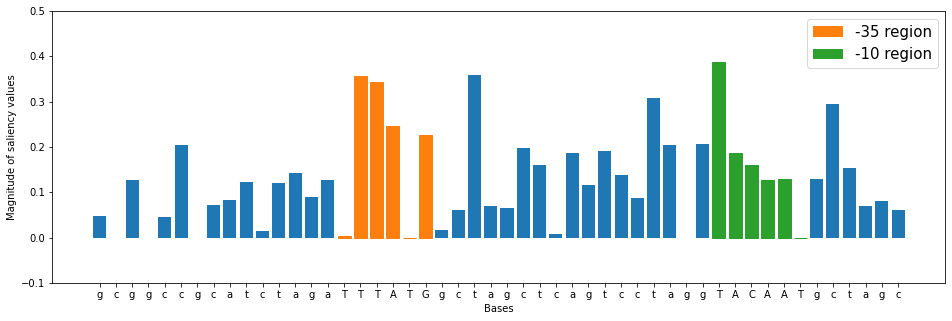

In [ ]:
generate_saliency_plot(anderson_weak)

Predicted promoter strength of gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc (Max is 1): 0.543


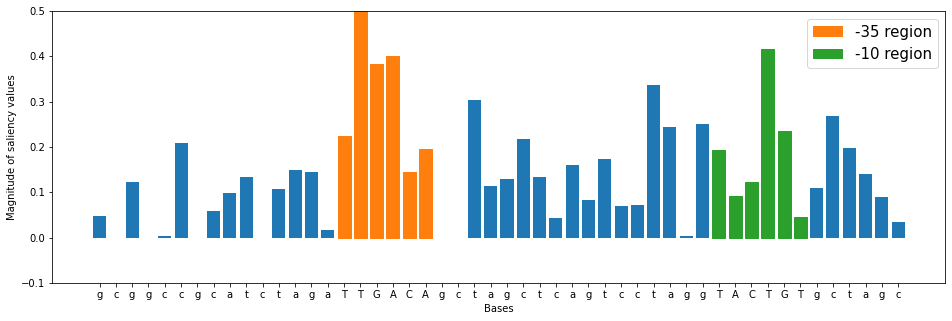

In [ ]:
generate_saliency_plot(anderson_strong)

Saliency maps are a way to visualize the influence each position and nucleotide has on the final score of the model. Above we have generated two saliency maps for the weak and strong anderson promoters respectively. The Anderson promoter designs were made such that only the $-10$ and $-35$ elements were modified between each design and the bases for the regions are highlighted and capitalized in the maps above.  The saliency map does give you information on which specific nucelotide and position will change the score the most if modified.  In the case of the strong anderson promoter, changing the second $T$ will likely affect the score the most.

While saliency maps can be useful, they must be interpreted individually and only for that specific sequence as the saliency map changes as the sequence changes.  This is very evident at the first $T$ in the $-35$ region of for both the weak and strong anderson promoter as both sequences have a $T$, in that position but the saliency value is much larger for the strong promoter.  So while it is useful to use the saliency map to gauge the importance of certain nucleotides and positions, it is not as simple that any individual nucleotide is "stronger" than another and sequence context matters.

With that said, below, if we change the second $T$ at the $-35$ in the strong Anderson promoter, we decrease the score from $0.54$ to $0.41$, thus making the mutated strong promoter closer to the strength of the weak Anderson promoter.

Predicted promoter strength of gcggccgcatctagaTgGACAgctagctcagtcctaggTACTGTgctagc (Max is 1): 0.414


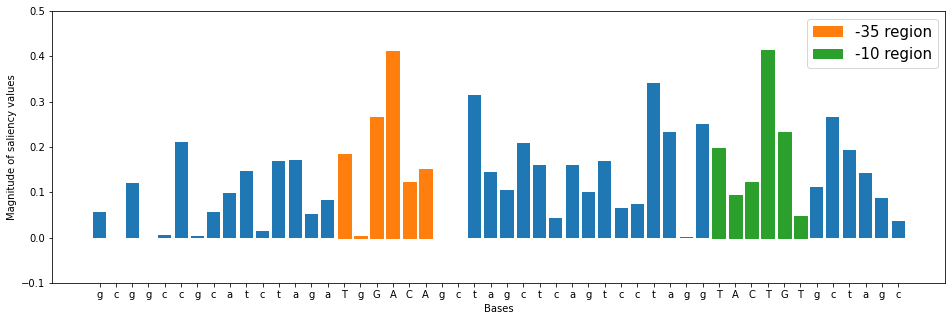

In [ ]:
anderson_salient_T_to_G = "gcggccgcatctagaTgGACAgctagctcagtcctaggTACTGTgctagc"
generate_saliency_plot(anderson_salient_T_to_G)

We can now try to design our own promoters using the CNN model and with the help of the biology you have learned in this lab as well as the saliency map.

**Question 28:** You are a promoter engineer for a biotech startup with limited resources.  You are tasked to create additional **50 nucleotide long promoters** of various strengths from the known Anderson promoters provided below. Times are tough and for each of your DNA-sequences you design, you can only **make a maximum of 5 mutations** to a sequence.  Luckily, your machine-learning engineers provide you a CNN model that can predict *E.coli* promoter strengths from 50nt DNA sequences.  Your designs must be based off of `anderson_weak`, `anderson_middle`, or `anderson_strong`.  You can make the nucleotide mutations anywhere, but remember that it is limited to 5 and also the sequences **must be 50 nucleotides in length**

Please design a promoter using one of the Anderson promoters below to hit a target strength of less than $0.33$ with $5$ mutations or less.

Please design a promoter using one of the Anderson promoters below to hit a target strength of greater than $0.6$ with $5$ mutations or less.

Predicted promoter strength of gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc (Max is 1): 0.543


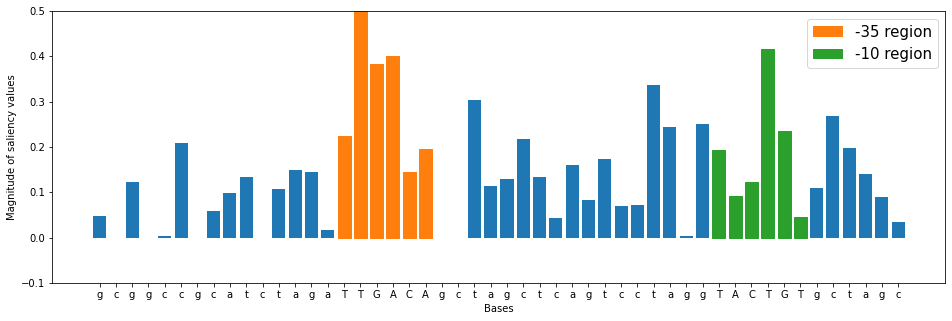

In [ ]:
anderson_weak = "gcggccgcatctagaTTTATGgctagctcagtcctaggTACAATgctagc"
anderson_middle = "gcggccgcatctagaCTGACAgctagctcagtcctaggTATAATgctagc"
anderson_strong = "gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc"

# You can test your sequences here by pasting them inside the function and re-running the cell
generate_saliency_plot("gcggccgcatctagaTTGACAgctagctcagtcctaggTACTGTgctagc")